# Analisis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Cambiar al directorio donde se encuentra el dataset
dataset_path = '/content/drive/My Drive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos'
os.listdir(dataset_path)  # Verifica los archivos en el directorio

Mounted at /content/drive


['readme.md',
 'Lexique - Data Analyst.xlsx',
 'extract - cash request - data analyst.csv',
 'extract - fees - data analyst - .csv',
 'extract - cash request - data analyst.gsheet',
 'extract - fees - data analyst - .gsheet',
 'payments_manager.py']

In [63]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
credit_requests = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - cash request - data analyst.csv')
# Crear una copia del DataFrame para preservar el original
cr = credit_requests.copy()

# Cargar el dataset de tarifas o fees para análisis de cohortes de tarifas
fees = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')
# Crear una copia del DataFrame para preservar el original
fs = fees.copy()

In [64]:
# Inspeccionar la estructura y el tipo de datos de 'cash_request'
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [65]:
# Filtrar columnas relevantes para el análisis
cr_flt = cr[["amount", "created_at", "user_id", "deleted_account_id", "transfer_type"]]
cr_flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amount              23970 non-null  float64
 1   created_at          23970 non-null  object 
 2   user_id             21867 non-null  float64
 3   deleted_account_id  2104 non-null   float64
 4   transfer_type       23970 non-null  object 
dtypes: float64(3), object(2)
memory usage: 936.5+ KB


In [66]:
# Renombrar 'id' a 'cash_id' para mayor claridad (y para el merge posterior con fees)
cr.rename(columns={'id': 'cash_id'}, inplace=True)

In [67]:
# Ver NA en columna 'user_id'
cr[cr['user_id'].notna()].nunique() # 21867 válidos
cr[cr['user_id'].isna()].nunique() # 2103 Nan
# Comprobación: 21867 válidos + 2103 NaN = 23970 filas

# Comprobar que 'user_id' y 'deteled_account_id' son complementarios
cr[cr['user_id'].isna() & cr['deleted_account_id'].isna()] # Empty dataframe -> Siempre tenemos un valor válido en una de las dos columnas

# Comprobar solapamientos
cr[cr['user_id'].notna() & cr['deleted_account_id'].notna()] # La fila crid=280 tiene user_id=3161 y a la vez deleted_account_id=262

,cash_id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
7313,280,100.0,money_back,2019-12-21 16:01:38.756985+00,2020-11-04 12:55:32.000656+00,3161.0,2019-12-22 13:48:26+00,262.0,2020-01-16 23:00:00+00,2019-12-24,2020-11-23 10:31:54.598593+00,regular,NaN,completed,2020-03-20 14:12:53.160242+00,2020-03-31 16:05:16.427692+00


In [68]:
# Nueva columna 'id_completo' a partir de user_id + deleted_account_id
cr.loc[:, 'id_completo'] = cr['user_id'].combine_first(cr['deleted_account_id'])
# Conversión de float a int
cr['id_completo'] = cr['id_completo'].astype(int)

In [69]:
# Convertir 'created_at' a tipo datetime para manipulación de fechas
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr.head()

,cash_id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,id_completo
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00:00,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,804
1,70,100.0,rejected,2019-12-10 19:50:12.347780+00:00,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,231
2,7,100.0,rejected,2019-12-10 19:13:35.825460+00:00,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,191
3,10,99.0,rejected,2019-12-10 19:16:10.880172+00:00,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,761
4,1594,100.0,rejected,2020-05-06 09:59:38.877376+00:00,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,7686


In [70]:
# Convertir la columna 'created_at' a una fecha sin zona horaria
cr['created_at'] = cr['created_at'].dt.tz_localize(None)
cr.head()

,cash_id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,id_completo
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,804
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,231
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,191
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,761
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,7686


In [71]:
# Crear columna 'Mes' indicando el mes de cada solicitud
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr.head()

,cash_id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,id_completo,Mes
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,804,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,231,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,191,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,761,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,7686,2020-05


In [72]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
cr['Cohorte'] = cr.groupby('id_completo')['created_at'].transform('min').dt.to_period('M')
cr.head(10)

,cash_id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,id_completo,Mes,Cohorte
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,804,2019-12,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,231,2019-12,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,191,2019-12,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,761,2019-12,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,7686,2020-05,2020-05
5,2145,100.0,money_back,2020-05-23 20:58:55.129432,2020-07-06 03:36:03.023911+00,9489.0,2020-05-24 12:40:33.05491+00,NaN,2020-06-06 22:00:00+00,2020-05-26,2020-07-06 03:36:03.023521+00,regular,NaN,completed,2020-06-12 22:27:04.837525+00,2020-07-06 03:36:03.030904+00,9489,2020-05,2020-05
6,3512,100.0,rejected,2020-06-16 17:07:38.452652,2020-06-17 10:21:21.364746+00,14631.0,2020-06-17 10:21:21.360742+00,NaN,2020-07-11 23:51:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,14631,2020-06,2020-06
7,654,100.0,rejected,2020-02-10 01:11:53.808270,2020-02-10 11:53:32.104131+00,NaN,2020-02-10 09:11:21.350695+00,309.0,2020-03-11 01:11:53.80793+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,309,2020-02,2020-01
8,5672,100.0,canceled,2020-06-28 12:06:33.712840,2020-06-28 12:06:33.712853+00,NaN,NaN,2499.0,2020-07-07 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2499,2020-06,2020-06
9,71,90.0,rejected,2019-12-10 19:51:23.911206,2019-12-12 15:06:11.192888+00,897.0,2019-12-12 15:06:11.190299+00,NaN,2019-12-17 19:51:23.910748+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,897,2019-12,2019-12


In [73]:
# Calcular el número inicial de clientes únicos en cada cohorte
cohort_sizes_initial = cr.groupby('Cohorte').agg(Num_Clientes_Iniciales=('id_completo', 'nunique')).reset_index()
cohort_sizes_initial

,Cohorte,Num_Clientes_Iniciales
0,2019-11,1
1,2019-12,254
2,2020-01,106
3,2020-02,90
4,2020-03,86
5,2020-04,246
6,2020-05,432
7,2020-06,1540
8,2020-07,1482
9,2020-08,728


In [74]:
# Calcular la cantidad de clientes únicos en cada cohorte para cada mes
cohort_sizes_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Clientes=('id_completo', 'nunique')).reset_index()
cohort_sizes_monthly

,Cohorte,Mes,Num_Clientes
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,680
79,2020-09,2020-11,20
80,2020-10,2020-10,4802
81,2020-10,2020-11,15


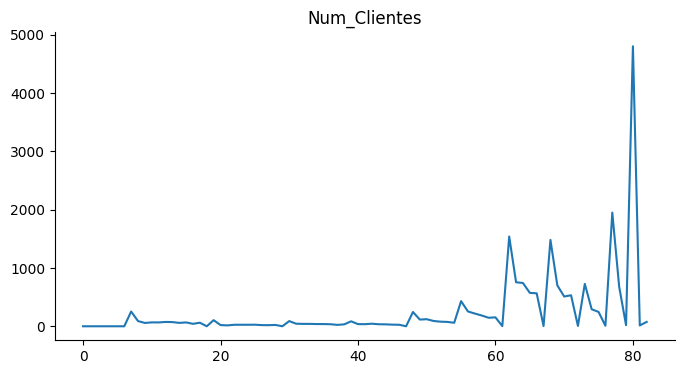

In [15]:
# @title Num_Clientes

from matplotlib import pyplot as plt
cohort_sizes_monthly['Num_Clientes'].plot(kind='line', figsize=(8, 4), title='Num_Clientes')
plt.gca().spines[['top', 'right']].set_visible(False)

In [16]:
# Calcular la cantidad de solicitudes de adelanto de efectivo de los clientes de cada cohorte en cada mes
cohort_cash_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Solicitudes=('id_completo', 'count')).reset_index()
cohort_cash_monthly

,Cohorte,Mes,Num_Solicitudes
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,727
79,2020-09,2020-11,20
80,2020-10,2020-10,5043
81,2020-10,2020-11,15


In [17]:
# Calcular la tasa de retención de clientes (clientes únicos por cohorte en cada mes / clientes iniciales de la cohorte)
retention_clientes = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes', values='Num_Clientes')
retention_clientes = retention_clientes.div(cohort_sizes_initial.set_index('Cohorte')['Num_Clientes_Iniciales'], axis=0)
retention_clientes

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,NaN
2019-12,NaN,1.0,0.354331,0.228346,0.267717,0.263780,0.295276,0.287402,0.232283,0.263780,0.169291,0.244094,0.003937
2020-01,NaN,NaN,1.000000,0.207547,0.150943,0.254717,0.254717,0.254717,0.264151,0.198113,0.188679,0.226415,0.009434
2020-02,NaN,NaN,NaN,1.000000,0.500000,0.466667,0.466667,0.433333,0.433333,0.400000,0.277778,0.377778,NaN
2020-03,NaN,NaN,NaN,NaN,1.000000,0.441860,0.430233,0.523256,0.418605,0.395349,0.337209,0.313953,0.011628
2020-04,NaN,NaN,NaN,NaN,NaN,1.000000,0.471545,0.495935,0.373984,0.325203,0.308943,0.247967,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.590278,0.506944,0.430556,0.340278,0.356481,0.009259
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.490909,0.482468,0.372727,0.367532,0.003247
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.474359,0.344804,0.359649,0.004723


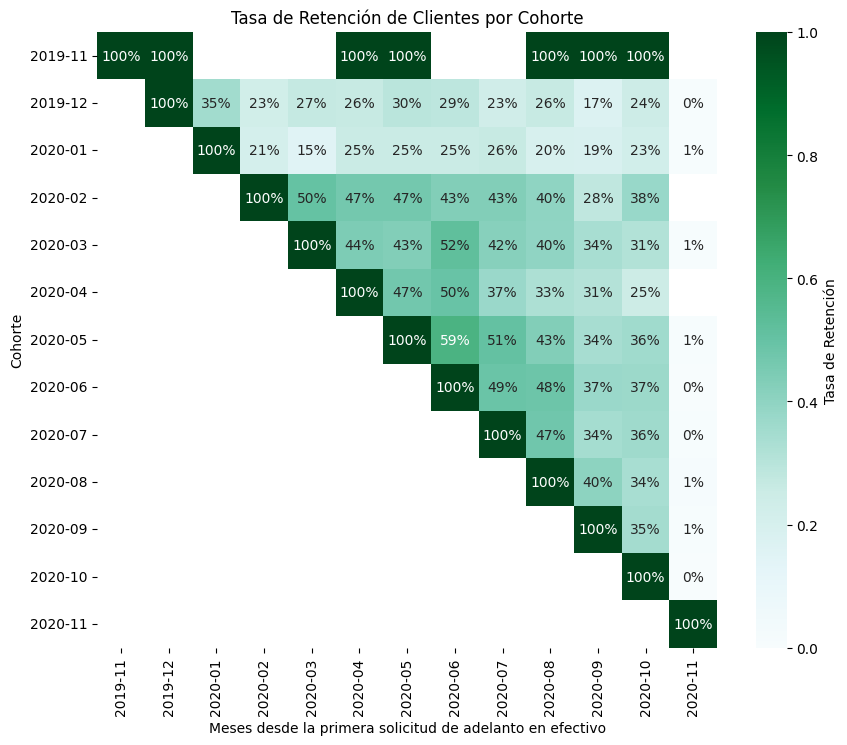

In [18]:
# Visualizar la tasa de retención de clientes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Clientes por Cohorte')
sns.heatmap(data=retention_clientes, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='BuGn', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()

In [19]:
# Calcular la tasa de abandono de clientes (1- tasa de retención)
churn_clientes = 1- retention_clientes

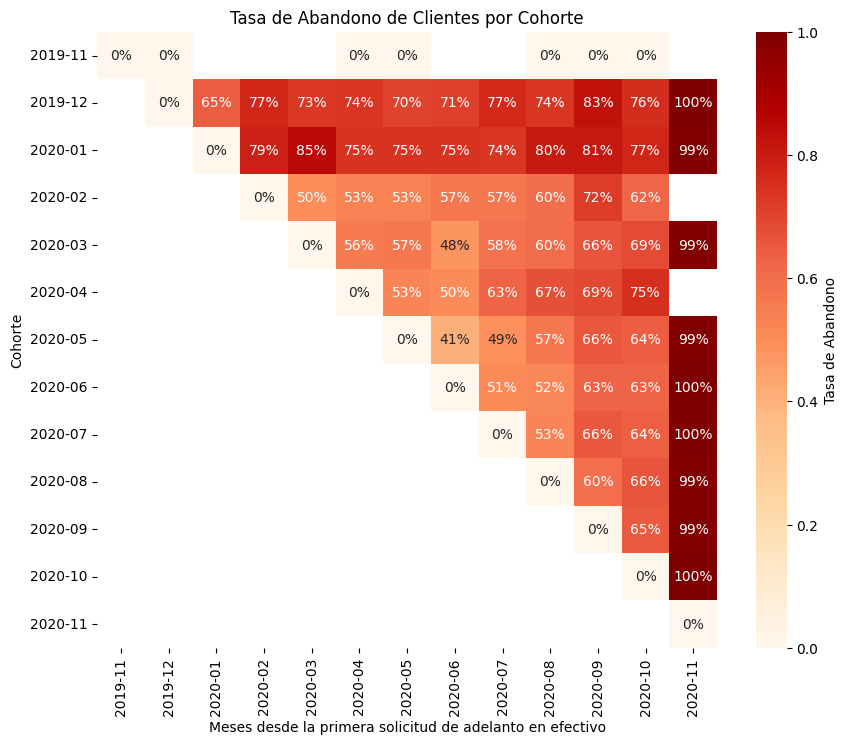

In [20]:
# Visualizar la tasa de abandono de clientes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Clientes por Cohorte')
sns.heatmap(data=churn_clientes, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='OrRd', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()

In [21]:
# Calcular el número inicial de solicitudes de adelanto de efectivo en cada cohorte
cohort_cash_initial = cohort_cash_monthly.groupby('Cohorte').first().reset_index().rename(columns={'Num_Solicitudes': 'Num_Solicitudes_Iniciales'})
cohort_cash_initial

,Cohorte,Mes,Num_Solicitudes_Iniciales
0,2019-11,2019-11,1
1,2019-12,2019-12,288
2,2020-01,2020-01,117
3,2020-02,2020-02,97
4,2020-03,2020-03,99
5,2020-04,2020-04,264
6,2020-05,2020-05,478
7,2020-06,2020-06,1934
8,2020-07,2020-07,1996
9,2020-08,2020-08,993


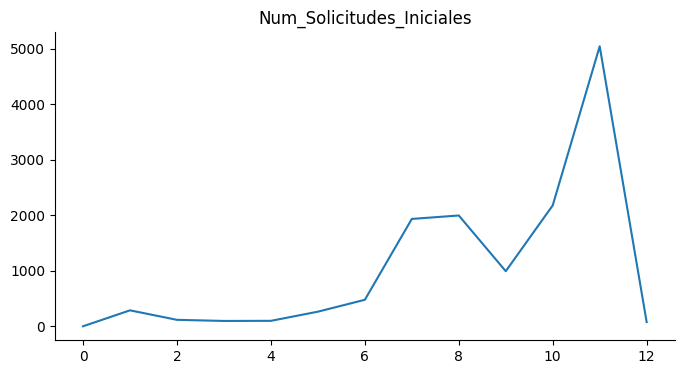

In [22]:
# @title Numero de Solicitudes Iniciales en cada cohorte

from matplotlib import pyplot as plt
cohort_cash_initial['Num_Solicitudes_Iniciales'].plot(kind='line', figsize=(8, 4), title='Num_Solicitudes_Iniciales')
plt.gca().spines[['top', 'right']].set_visible(False)

In [23]:
# @title Calcular la tasa de retención de solicitudes (solicitudes por cohorte en cada mes / solicitudes iniciales de la cohorte)
retention_cash = cohort_cash_monthly.pivot(index='Cohorte', columns='Mes', values='Num_Solicitudes')
retention_cash = retention_cash.div(cohort_cash_initial.set_index('Cohorte')['Num_Solicitudes_Iniciales'], axis=0)
retention_cash

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,2.000000,NaN
2019-12,NaN,1.0,0.368056,0.218750,0.274306,0.284722,0.298611,0.315972,0.250000,0.291667,0.184028,0.260417,0.003472
2020-01,NaN,NaN,1.000000,0.205128,0.145299,0.299145,0.264957,0.247863,0.264957,0.188034,0.188034,0.213675,0.008547
2020-02,NaN,NaN,NaN,1.000000,0.505155,0.505155,0.463918,0.463918,0.463918,0.453608,0.278351,0.412371,NaN
2020-03,NaN,NaN,NaN,NaN,1.000000,0.424242,0.464646,0.474747,0.404040,0.363636,0.303030,0.303030,0.010101
2020-04,NaN,NaN,NaN,NaN,NaN,1.000000,0.568182,0.571970,0.439394,0.405303,0.337121,0.284091,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.665272,0.573222,0.485356,0.376569,0.364017,0.008368
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.531024,0.494829,0.355222,0.339193,0.002585
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.471443,0.304609,0.298096,0.003507


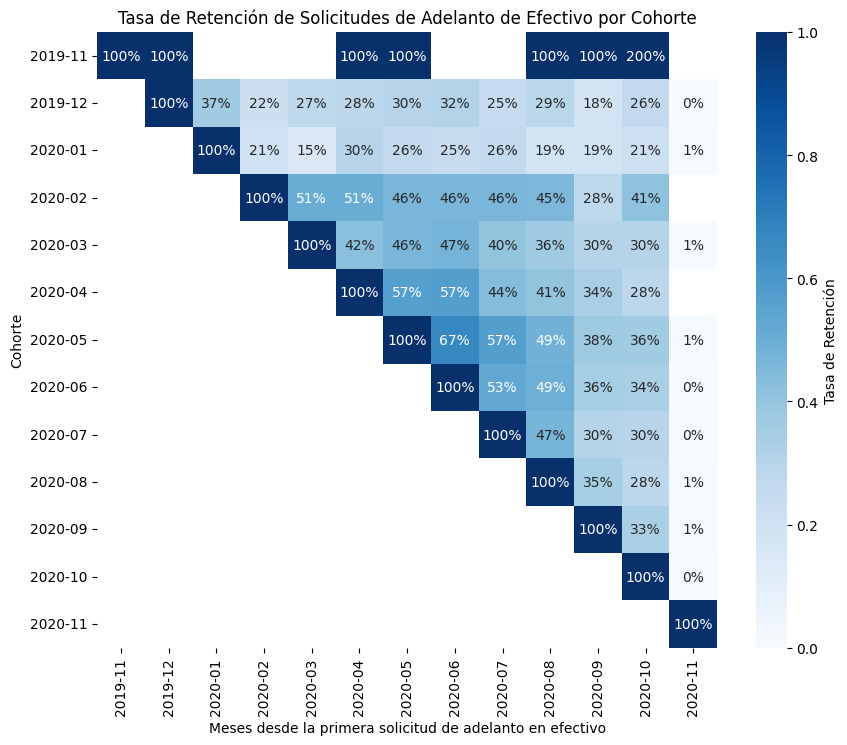

In [24]:
# Visualizar la tasa de retención de solicitudes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Solicitudes de Adelanto de Efectivo por Cohorte')
sns.heatmap(data=retention_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='Blues', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()

In [25]:
# Calcular la tasa de abandono de solicitudes (1- tasa de retención de solicitudes)
churn_cash = 1- retention_cash
churn_cash

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,0.0,0.0,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,-1.000000,NaN
2019-12,NaN,0.0,0.631944,0.781250,0.725694,0.715278,0.701389,0.684028,0.750000,0.708333,0.815972,0.739583,0.996528
2020-01,NaN,NaN,0.000000,0.794872,0.854701,0.700855,0.735043,0.752137,0.735043,0.811966,0.811966,0.786325,0.991453
2020-02,NaN,NaN,NaN,0.000000,0.494845,0.494845,0.536082,0.536082,0.536082,0.546392,0.721649,0.587629,NaN
2020-03,NaN,NaN,NaN,NaN,0.000000,0.575758,0.535354,0.525253,0.595960,0.636364,0.696970,0.696970,0.989899
2020-04,NaN,NaN,NaN,NaN,NaN,0.000000,0.431818,0.428030,0.560606,0.594697,0.662879,0.715909,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.334728,0.426778,0.514644,0.623431,0.635983,0.991632
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.468976,0.505171,0.644778,0.660807,0.997415
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.528557,0.695391,0.701904,0.996493


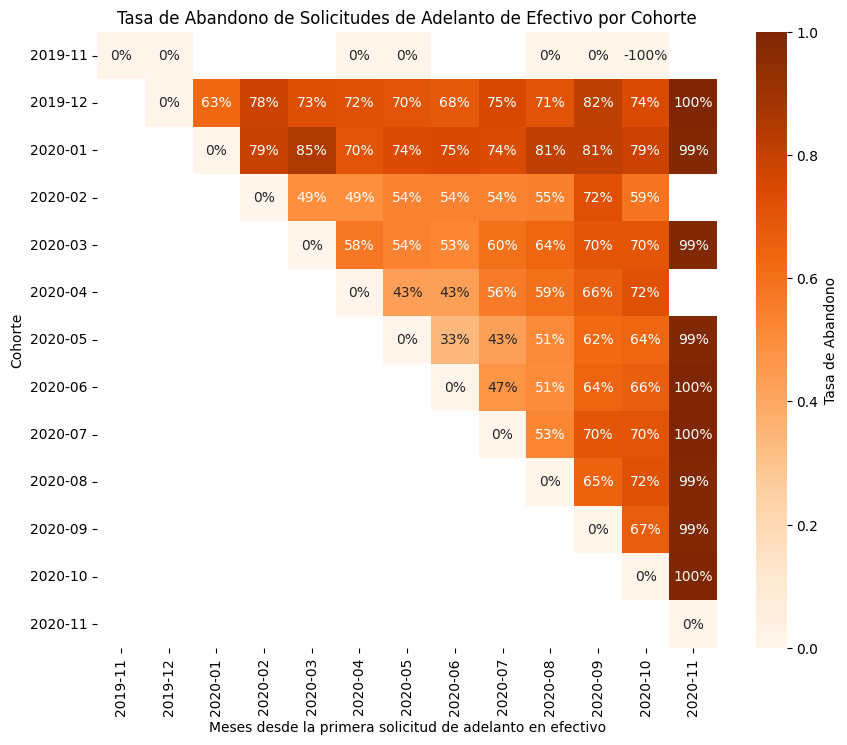

In [26]:
# Visualizar la tasa de abandono de solicitudes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Solicitudes de Adelanto de Efectivo por Cohorte')
sns.heatmap(data=churn_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='Oranges', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()

In [27]:
grouped1st = cr.pivot_table(
    values = "created_at",
    index = "id_completo",
    aggfunc = "min"
)
warnings.filterwarnings('ignore', category=UserWarning)
grouped1st['cohorte'] = grouped1st['created_at'].dt.to_period('M')
warnings.resetwarnings()
grouped1st.head()

,created_at,cohorte
id_completo,,
34,2020-04-20 15:50:21.187257,2020-04
35,2019-12-13 20:27:38.106778,2019-12
47,2019-11-19 13:57:53.511561,2019-11
52,2019-12-17 09:01:12.584634,2019-12
53,2019-12-21 11:39:03.844436,2019-12


In [28]:
# Calcular valores más legibles para 'cohorte', sobre todo para que a la hora de graficar no se confundan con el eje temporal
# NB. Esta necesidad la hemos visto a posteriori...
claves = list(np.sort(grouped1st['cohorte'].unique()))
claves
valores = []
# Calcular valores más legibles para 'cohorte', sobre todo para que a la hora de graficar no se confundan con el eje temporal
# NB. Esta necesidad la hemos visto a posteriori...
claves = list(np.sort(grouped1st['cohorte'].unique()))
claves
valores = []
for index, value in enumerate(claves):
    #valores.append(f'COH-{index+1:02}.{value.strftime('%b')}/{str(value.year)}')
    valores.append(f'COH-{index+1:02}.{value.strftime("%b")}/{str(value.strftime("%y"))}')
valores
labels = dict(zip(claves, valores))
labels
labels

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{Period('2019-11', 'M'): 'COH-01.Nov/19',
 Period('2019-12', 'M'): 'COH-02.Dec/19',
 Period('2020-01', 'M'): 'COH-03.Jan/20',
 Period('2020-02', 'M'): 'COH-04.Feb/20',
 Period('2020-03', 'M'): 'COH-05.Mar/20',
 Period('2020-04', 'M'): 'COH-06.Apr/20',
 Period('2020-05', 'M'): 'COH-07.May/20',
 Period('2020-06', 'M'): 'COH-08.Jun/20',
 Period('2020-07', 'M'): 'COH-09.Jul/20',
 Period('2020-08', 'M'): 'COH-10.Aug/20',
 Period('2020-09', 'M'): 'COH-11.Sep/20',
 Period('2020-10', 'M'): 'COH-12.Oct/20',
 Period('2020-11', 'M'): 'COH-13.Nov/20'}

In [29]:
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cash_id                     23970 non-null  int64         
 1   amount                      23970 non-null  float64       
 2   status                      23970 non-null  object        
 3   created_at                  23970 non-null  datetime64[ns]
 4   updated_at                  23970 non-null  object        
 5   user_id                     21867 non-null  float64       
 6   moderated_at                16035 non-null  object        
 7   deleted_account_id          2104 non-null   float64       
 8   reimbursement_date          23970 non-null  object        
 9   cash_request_received_date  16289 non-null  object        
 10  money_back_date             16543 non-null  object        
 11  transfer_type               23970 non-null  object    

In [30]:
# Añadir dato 'cohorte_lbl' a tabla de trabajo
cr['cohorte_lbl'] = cr['Cohorte'].transform(lambda x: labels[x])
cr.sample(30)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cash_id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,id_completo,Mes,Cohorte,cohorte_lbl
1433,3626,100.0,rejected,2020-06-17 12:35:07.561976,2020-06-17 13:26:42.098087+00,16001.0,2020-06-17 13:26:42.094337+00,NaN,2020-07-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,16001,2020-06,2020-06,COH-08.Jun/20
5650,16533,50.0,rejected,2020-09-17 06:46:50.040844,2020-09-17 08:42:14.368399+00,42463.0,2020-09-17 08:42:14.358073+00,NaN,2020-10-05 23:51:00+00,NaN,NaN,instant,2020-09-24 06:46:50.016926+00,NaN,NaN,NaN,42463,2020-09,2020-09,COH-11.Sep/20
14143,11322,50.0,money_back,2020-08-07 11:01:30.519340,2020-12-18 13:10:01.75668+00,15409.0,2020-08-07 13:02:04.123743+00,NaN,2020-08-21 11:01:45.838+00,2020-08-11,2020-08-29 22:12:23.812361+00,instant,2020-08-14 11:01:30.518974+00,completed,2020-08-29 22:12:20.742161+00,2020-08-29 22:12:23.827709+00,15409,2020-08,2020-08,COH-10.Aug/20
21300,25709,25.0,money_back,2020-10-28 16:39:55.034747,2020-12-18 13:12:52.226215+00,81164.0,NaN,NaN,2020-11-04 23:51:00+00,2020-10-30,2020-11-04 18:13:43.566391+00,instant,2020-10-28 16:40:20.752562+00,NaN,NaN,NaN,81164,2020-10,2020-10,COH-12.Oct/20
14877,13509,100.0,money_back,2020-08-21 16:00:12.041105,2020-12-18 13:10:20.940016+00,17595.0,NaN,NaN,2020-09-07 22:00:00+00,2020-08-24,2020-09-09 19:53:38.845365+00,instant,2020-08-28 16:00:11.99547+00,NaN,NaN,NaN,17595,2020-08,2020-06,COH-08.Jun/20
11585,5331,100.0,money_back,2020-06-25 13:42:13.446009,2020-12-18 13:09:09.377467+00,13929.0,2020-06-25 15:50:17.027853+00,NaN,2020-09-06 17:44:05.582+00,2020-06-30,2020-09-06 19:46:06.058761+00,regular,NaN,NaN,NaN,NaN,13929,2020-06,2020-06,COH-08.Jun/20
11476,5066,100.0,money_back,2020-06-25 02:31:01.256438,2020-12-18 13:09:06.964857+00,3160.0,2020-06-25 12:29:59.002477+00,NaN,2020-07-09 22:00:00+00,2020-06-27,2020-07-09 22:00:00+00,regular,NaN,NaN,NaN,NaN,3160,2020-06,2020-03,COH-05.Mar/20
16875,12592,100.0,money_back,2020-08-15 08:04:29.649991,2020-12-18 13:11:04.191+00,NaN,2020-08-15 11:11:08.747432+00,11769.0,2020-09-07 22:00:00+00,2020-08-18,2020-10-11 17:44:56.6809+00,instant,2020-08-22 08:04:29.599127+00,completed,2020-09-21 22:52:08.06461+00,2020-10-11 17:44:56.697563+00,11769,2020-08,2020-06,COH-08.Jun/20
23250,24020,50.0,money_back,2020-10-24 11:10:18.255121,2020-12-18 13:14:33.409338+00,90262.0,NaN,NaN,2020-11-04 22:00:00+00,2020-10-27,2020-12-05 04:29:54.294796+00,instant,2020-10-24 11:10:39.565807+00,completed,2020-11-15 22:35:16.713751+00,2020-12-05 04:29:54.298043+00,90262,2020-10,2020-10,COH-12.Oct/20
9277,1083,100.0,money_back,2020-04-08 13:31:34.875644,2020-11-04 12:55:09.166002+00,5413.0,2020-04-08 16:59:27.944765+00,NaN,2020-04-21 22:00:00+00,2020-04-09,2020-11-23 10:32:42.261895+00,regular,NaN,completed,2020-04-22 20:50:58.820098+00,2020-06-18 22:15:23.300421+00,5413,2020-04,2020-04,COH-06.Apr/20


In [31]:
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cash_id                     23970 non-null  int64         
 1   amount                      23970 non-null  float64       
 2   status                      23970 non-null  object        
 3   created_at                  23970 non-null  datetime64[ns]
 4   updated_at                  23970 non-null  object        
 5   user_id                     21867 non-null  float64       
 6   moderated_at                16035 non-null  object        
 7   deleted_account_id          2104 non-null   float64       
 8   reimbursement_date          23970 non-null  object        
 9   cash_request_received_date  16289 non-null  object        
 10  money_back_date             16543 non-null  object        
 11  transfer_type               23970 non-null  object    

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Análisis de Cohortes para Fees

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Cambiar al directorio donde se encuentra el dataset
dataset_path = '/content/drive/My Drive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos'
os.listdir(dataset_path)  # Verifica los archivos en el directorio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['readme.md',
 'Lexique - Data Analyst.xlsx',
 'extract - cash request - data analyst.csv',
 'extract - fees - data analyst - .csv',
 'extract - cash request - data analyst.gsheet',
 'extract - fees - data analyst - .gsheet',
 'payments_manager.py']

In [34]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
fees = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')
# Crear una copia del DataFrame para preservar el original
fs = fees.copy()
# Inspeccionar la estructura y el tipo de datos de 'cash_request'
fees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21061 non-null  int64  
 1   cash_request_id  21057 non-null  float64
 2   type             21061 non-null  object 
 3   status           21061 non-null  object 
 4   category         2196 non-null   object 
 5   total_amount     21061 non-null  float64
 6   reason           21061 non-null  object 
 7   created_at       21061 non-null  object 
 8   updated_at       21061 non-null  object 
 9   paid_at          15531 non-null  object 
 10  from_date        7766 non-null   object 
 11  to_date          7766 non-null   object 
 12  charge_moment    21061 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.1+ MB


In [35]:
# Filtrar columnas relevantes para el análisis
fs = fs[["cash_request_id", "total_amount", "created_at"]]
fs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cash_request_id  21057 non-null  float64
 1   total_amount     21061 non-null  float64
 2   created_at       21061 non-null  object 
dtypes: float64(2), object(1)
memory usage: 493.7+ KB


In [36]:
# Convertir la columna 'created_at' en fees a tipo datetime para análisis temporal
fs['created_at'] = pd.to_datetime(fs['created_at'])
fs.head()

,cash_request_id,total_amount,created_at
0,14941.0,5.0,2020-09-07 10:47:27.423150+00:00
1,11714.0,5.0,2020-09-09 20:51:17.998653+00:00
2,23371.0,5.0,2020-10-23 10:10:58.352972+00:00
3,26772.0,5.0,2020-10-31 15:46:53.643958+00:00
4,19350.0,5.0,2020-10-06 08:20:17.170432+00:00


In [37]:
 # Convertir la columna 'created_at' a una fecha sin zona horaria
fs['created_at'] = fs['created_at'].dt.tz_localize(None)
fs.head()

,cash_request_id,total_amount,created_at
0,14941.0,5.0,2020-09-07 10:47:27.423150
1,11714.0,5.0,2020-09-09 20:51:17.998653
2,23371.0,5.0,2020-10-23 10:10:58.352972
3,26772.0,5.0,2020-10-31 15:46:53.643958
4,19350.0,5.0,2020-10-06 08:20:17.170432


In [38]:
# Crear columna 'Mes' indicando el mes de cada solicitud
fs['Mes'] = fs['created_at'].dt.to_period('M')
fs.head()

,cash_request_id,total_amount,created_at,Mes
0,14941.0,5.0,2020-09-07 10:47:27.423150,2020-09
1,11714.0,5.0,2020-09-09 20:51:17.998653,2020-09
2,23371.0,5.0,2020-10-23 10:10:58.352972,2020-10
3,26772.0,5.0,2020-10-31 15:46:53.643958,2020-10
4,19350.0,5.0,2020-10-06 08:20:17.170432,2020-10


In [39]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
fs['Cohorte'] = fs.groupby('cash_request_id')['created_at'].transform('min').dt.to_period('M')
fs.head(10)

,cash_request_id,total_amount,created_at,Mes,Cohorte
0,14941.0,5.0,2020-09-07 10:47:27.423150,2020-09,2020-09
1,11714.0,5.0,2020-09-09 20:51:17.998653,2020-09,2020-08
2,23371.0,5.0,2020-10-23 10:10:58.352972,2020-10,2020-10
3,26772.0,5.0,2020-10-31 15:46:53.643958,2020-10,2020-10
4,19350.0,5.0,2020-10-06 08:20:17.170432,2020-10,2020-10
5,24052.0,5.0,2020-10-24 12:22:27.666102,2020-10,2020-10
6,25983.0,5.0,2020-10-30 04:38:06.826149,2020-10,2020-10
7,14839.0,5.0,2020-10-16 23:48:50.655967,2020-10,2020-09
8,26572.0,5.0,2020-10-31 05:29:08.471800,2020-10,2020-10
9,22106.0,5.0,2020-10-21 08:48:50.696961,2020-10,2020-10


In [40]:
# Calcular la cantidad de tarifas iniciales por cohorte
cohort_fees_initial = fs.groupby('Cohorte').agg(Num_Tarifas_Iniciales=('cash_request_id', 'nunique')).reset_index()
cohort_fees_initial

,Cohorte,Num_Tarifas_Iniciales
0,2020-05,14
1,2020-06,447
2,2020-07,856
3,2020-08,1922
4,2020-09,2640
5,2020-10,6930
6,2020-11,124


In [41]:
# Calcular el número de tarifas en cada cohorte para cada mes
cohort_fees_monthly = fs.groupby(['Cohorte', 'Mes']).agg(Num_Tarifas=('cash_request_id', 'nunique')).reset_index()
cohort_fees_monthly

,Cohorte,Mes,Num_Tarifas
0,2020-05,2020-05,14
1,2020-05,2020-06,5
2,2020-05,2020-07,2
3,2020-05,2020-08,1
4,2020-05,2020-09,1
5,2020-05,2020-10,1
6,2020-06,2020-06,447
7,2020-06,2020-07,196
8,2020-06,2020-08,74
9,2020-06,2020-09,42


In [42]:
# Calcular la tasa de retención de tarifas (número de tarifas de cada cohorte en cada mes / tarifas iniciales de la cohorte)
retention_fees = cohort_fees_monthly.pivot(index='Cohorte', columns='Mes', values='Num_Tarifas')
retention_fees = retention_fees.div(cohort_fees_initial.set_index('Cohorte')['Num_Tarifas_Iniciales'], axis=0)
retention_fees

Mes,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,
2020-05,1.0,0.357143,0.142857,0.071429,0.071429,0.071429,NaN
2020-06,NaN,1.000000,0.438479,0.165548,0.093960,0.082774,NaN
2020-07,NaN,NaN,1.000000,0.371495,0.200935,0.143692,NaN
2020-08,NaN,NaN,NaN,1.000000,0.356400,0.197190,NaN
2020-09,NaN,NaN,NaN,NaN,1.000000,0.360985,0.006439
2020-10,NaN,NaN,NaN,NaN,NaN,1.000000,0.014286
2020-11,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


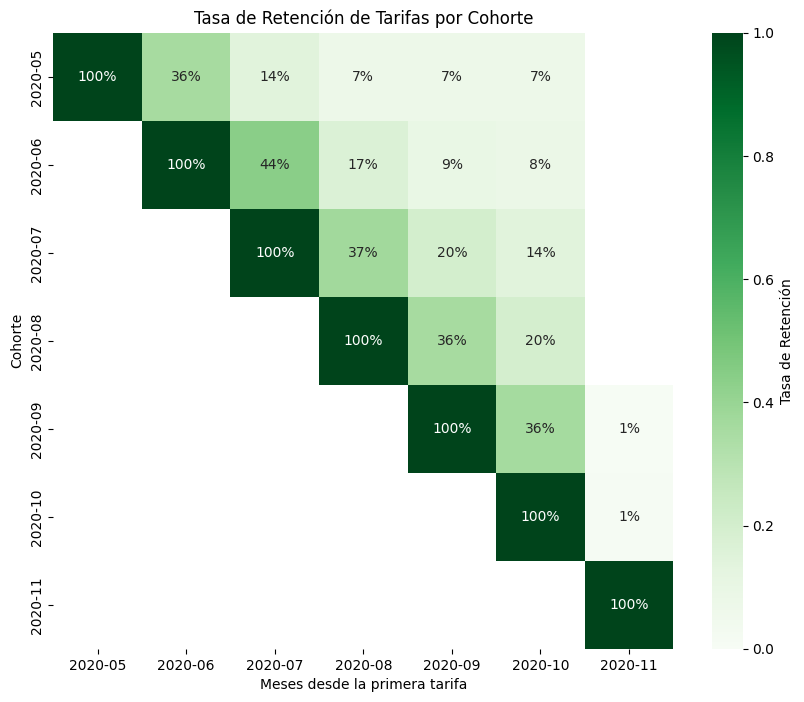

In [43]:
# Visualizar la tasa de retención de tarifas usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Tarifas por Cohorte')
sns.heatmap(data=retention_fees, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Greens', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera tarifa')
plt.ylabel('Cohorte')
plt.show()

In [44]:
# Calcular la tasa de abandono de tarifas (1- tasa de retención de tarifas)
churn_fees = 1- retention_fees

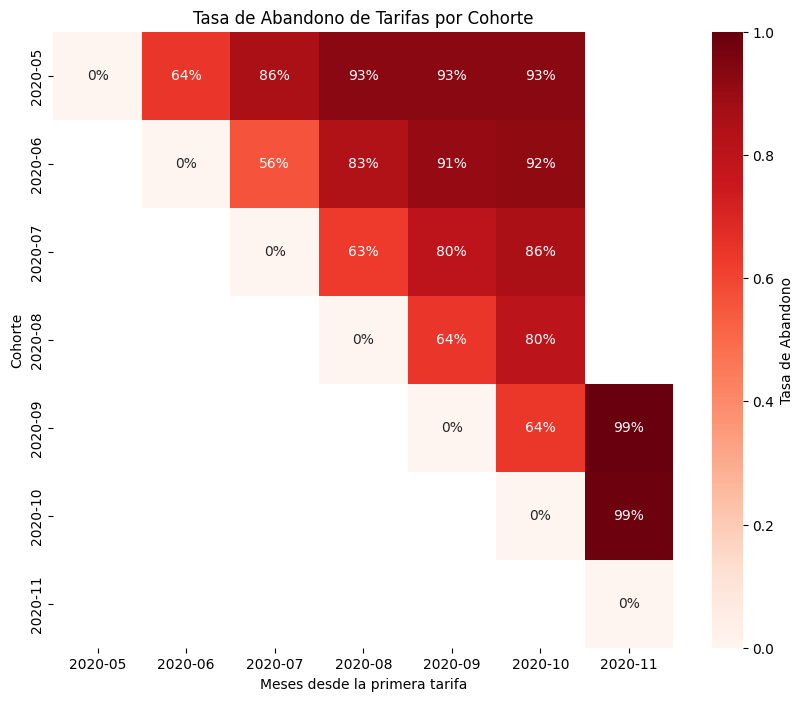

In [45]:
# Visualizar la tasa de abandono de tarifas usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Tarifas por Cohorte')
sns.heatmap(data=churn_fees, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='Reds', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera tarifa')
plt.ylabel('Cohorte')
plt.show()

## **Parte Merge**

In [46]:
def evaluate_polynomial_linear_regression(df, feature_col, target_col, poly_degrees=[1, 2, 3, 4, 5],
                                         test_size=0.2, extrapolation_size=0.2, random_state=42 , polynomial_features=1):

    """
    Evaluate Polynomial Linear Regression models with confidence intervals.

    Parameters:
    - df: pandas DataFrame, the dataset containing the feature and target columns.
    - feature_col: str, the name of the feature column.
    - target_col: str, the name of the target column.
    - poly_degrees: list, polynomial degrees to test.
    - test_size: float, proportion of the dataset to include in the test split.
    - extrapolation_size: float, proportion of the dataset to include in the extrapolation split.
    - random_state: int, random seed for reproducibility.

    Returns:
    - None (plots and prints evaluation metrics).
    """

    # Remove NaN values
    df_train = df.dropna()

    # Create Polynomial Features
    if polynomial_features > 1:
        poly = PolynomialFeatures(degree=polynomial_features, include_bias=False)
        X_poly = poly.fit_transform(df_train[[feature_col]])
        X = np.array(X_poly)
    else:
        X = np.array(df_train[[feature_col]])

    # Convert target variable to numpy array
    y = np.array(df_train[target_col])


    # Split dataset into interpolation and extrapolation sets
    X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=extrapolation_size,
                                                              random_state=random_state, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=test_size,
                                                        shuffle=True, random_state=random_state)

    # Loop through each polynomial degree
    for degree in poly_degrees:
        # Create and fit the Linear Regression Model with Polynomial Features
        linear_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        linear_model.fit(X_train, y_train)  # Train model

        # Predictions
        linear_train_preds = linear_model.predict(X_train)
        linear_test_preds = linear_model.predict(X_test)
        linear_y_predict_interp = linear_model.predict(X_interp)
        linear_y_predict_extra = linear_model.predict(X_extrap)

        # Compute Standard Deviation of Prediction Errors
        linear_std = np.std(y_train - linear_train_preds)

        # Compute Performance Metrics
        linear_mse_train = mean_squared_error(y_train, linear_train_preds)
        linear_mse_test = mean_squared_error(y_test, linear_test_preds)
        R2_sklearn_train = r2_score(y_train, linear_train_preds)
        R2_sklearn_test = r2_score(y_test, linear_test_preds)
        R2_sklearn_extrap = r2_score(y_extrap, linear_y_predict_extra)

        # Plot results for this degree
        plt.figure(figsize=(10, 6))
        print(X_train.shape,y_train.shape)
        plt.scatter(X_train[:,0].flatten(), y_train, label='Train (Interpolation)', color='blue', alpha=0.5)
        plt.scatter(X_test[:,0].flatten(), y_test, label='Test (Interpolation)', color='green', alpha=0.5)
        plt.scatter(X_extrap[:,0].flatten(), y_extrap, label='Extrapolation Real', color='orange', alpha=0.5)
        plt.plot(X_interp[:,0].flatten(), linear_y_predict_interp, label='Linear Trend (Interpolation)', color='red', linewidth=2)
        plt.plot(X_extrap[:,0].flatten(), linear_y_predict_extra, label='Linear Trend (Extrapolation)', color='gray', linewidth=2)

        # Add standard deviation bands
        plt.fill_between(X_interp[:,0].flatten(), linear_y_predict_interp - linear_std, linear_y_predict_interp + linear_std,
                         color='red', alpha=0.2, label='±1 Std Dev')
        plt.fill_between(X_extrap[:,0].flatten(), linear_y_predict_extra - linear_std, linear_y_predict_extra + linear_std,
                         color='gray', alpha=0.2)

        plt.title(f'Polynomial Linear Regression (Degree {degree})')
        plt.xlabel(feature_col)
        plt.ylabel(target_col)
        plt.legend()
        plt.show()

        # Print Performance Metrics
        print(f"Degree {degree}:")
        print(f" - Train MSE: {linear_mse_train:.4f}")
        print(f" - Test MSE: {linear_mse_test:.4f}")
        print(f" - R² Score (Train): {R2_sklearn_train:.4f}")
        print(f" - R² Score (Test): {R2_sklearn_test:.4f}")
        print(f" - R² Score (Extrapolation): {R2_sklearn_extrap:.4f}")
        print("=" * 60)

## **Cohorte inicio 2019-12**

In [47]:
cohort_2019_12 = retention_request.loc['2019-12']  # Keep double brackets to retain DataFrame structure


df = cohort_2019_12.reset_index()  # Select first two columns dynamically
df.columns = ['Month', 'Retention_Rate']
df = df.iloc[:-1]
# Convert 'Month' from Period to datetime
df['Month'] = df['Month'].astype(str)  # Convert to string
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df['Month_Num'] = (df['Month'] - df['Month'].min()).dt.days // 30

df

NameError: name 'retention_request' is not defined

In [ ]:
evaluate_polynomial_linear_regression(df,'Month_Num','Retention_Rate',polynomial_features=2)

## **Cohorte inicio 2020-01**

In [ ]:
cohort_2020_01 = retention_request.loc['2020-01']
df_2020_01 = cohort_2020_01.reset_index()

df_2020_01.columns = ['Month', 'Retention_Rate']
df_2020_01 = df_2020_01.iloc[:-1]
# Convert 'Month' from Period to datetime
df_2020_01['Month'] = df_2020_01['Month'].astype(str)  # Convert to string
df_2020_01['Month'] = pd.to_datetime(df_2020_01['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df_2020_01['Month_Num'] = (df_2020_01['Month'] - df_2020_01['Month'].min()).dt.days // 30

df_2020_01

In [ ]:
evaluate_polynomial_linear_regression(df_2020_01,'Month_Num','Retention_Rate')

## **Cohorte inicio 2020-02**

In [ ]:
cohort_2020_02 = retention_request.loc['2020-02']
df_2020_02 = cohort_2020_02.reset_index()

df_2020_02.columns = ['Month', 'Retention_Rate']
df_2020_02 = df_2020_02.iloc[:-1]
# Convert 'Month' from Period to datetime
df_2020_02['Month'] = df_2020_02['Month'].astype(str)  # Convert to string
df_2020_02['Month'] = pd.to_datetime(df_2020_02['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df_2020_02['Month_Num'] = (df_2020_02['Month'] - df_2020_02['Month'].min()).dt.days // 30
df_2020_02['Month_Num'] = df_2020_02['Month_Num'].astype(int)
df_2020_02

In [ ]:
evaluate_polynomial_linear_regression(df_2020_02,'Month_Num','Retention_Rate')

In [48]:
# Merge datasets using cash_request_id from fees and cash_id from cash_request
merged_df = cr.merge(fs, left_on='cash_id', right_on='cash_request_id', how='left')

# Drop redundant columns (ensure 'id_y' exists before dropping)
if 'id_y' in merged_df.columns:
    merged_df = merged_df.drop(columns=["id_y"])

# Rename columns for clarity
merged_df.rename(columns={"id_x": "fee_id"}, inplace=True)

#  Correct Column Naming
if 'created_at_y' in merged_df.columns:  # Prefer cash request date
    merged_df['created_at_cash_request'] = merged_df['created_at_y']
    merged_df = merged_df.drop(columns=["created_at_y"])
    if 'created_at_x' in merged_df.columns:  # Use fee date if cash request date is missing
        merged_df['created_at_fees'] = merged_df['created_at_x']
        merged_df = merged_df.drop(columns=["created_at_x"])
else:
    raise KeyError("Column 'created_at' not found in merged dataset")

#  Convert 'created_at_cash_request' to datetime
merged_df['created_at_cash_request'] = pd.to_datetime(merged_df['created_at_cash_request'], errors='coerce')

#  Create Month Column for Cash Request
merged_df['Month_cash_request'] = merged_df['created_at_cash_request'].dt.to_period('M')
merged_df['Month_cash_request'] = merged_df['Month_cash_request'].astype(str)  # Convert to string
merged_df['Month_cash_request'] = pd.to_datetime(merged_df['Month_cash_request'], format='%Y-%m')

merged_df['Month_Num_cash_request'] = ((merged_df['Month_cash_request'] - merged_df['Month_cash_request'].min()).dt.days // 30)

#  Convert 'created_at_fees' to datetime
merged_df['created_at_fees'] = pd.to_datetime(merged_df['created_at_fees'], errors='coerce')

#  Create Month Column for Fees
merged_df['Month_fees'] = merged_df['created_at_fees'].dt.to_period('M')
merged_df['Month_fees'] = merged_df['Month_fees'].astype(str)  # Convert to string
merged_df['Month_fees'] = pd.to_datetime(merged_df['Month_fees'], format='%Y-%m')

merged_df['Month_Num_fees'] = ((merged_df['Month_fees'] - merged_df['Month_fees'].min()).dt.days // 30)

#  Display the merged dataset info
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cash_id                     32094 non-null  int64         
 1   amount                      32094 non-null  float64       
 2   status                      32094 non-null  object        
 3   updated_at                  32094 non-null  object        
 4   user_id                     29522 non-null  float64       
 5   moderated_at                21759 non-null  object        
 6   deleted_account_id          2573 non-null   float64       
 7   reimbursement_date          32094 non-null  object        
 8   cash_request_received_date  24149 non-null  object        
 9   money_back_date             23917 non-null  object        
 10  transfer_type               32094 non-null  object        
 11  send_at                     22678 non-null  object    

In [49]:
import plotly.express as px

fig= px.imshow(merged_df.isnull(),
              color_continuous_scale=['gray','green'],
              labels=dict(color='NaN'),
              title='Color Map for the Merged Data Frame(Left Join)')
fig.update_layout(width=700, height=700)
fig.update_coloraxes(showscale= False)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [50]:
merged_df.head()

,cash_id,amount,status,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,...,cash_request_id,total_amount,Mes_y,Cohorte_y,created_at_cash_request,created_at_fees,Month_cash_request,Month_Num_cash_request,Month_fees,Month_Num_fees
0,5,100.0,rejected,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,...,NaN,NaN,NaT,NaT,NaT,2019-12-10 19:05:21.596873,NaT,NaN,2019-12-01,1
1,70,100.0,rejected,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,...,NaN,NaN,NaT,NaT,NaT,2019-12-10 19:50:12.347780,NaT,NaN,2019-12-01,1
2,7,100.0,rejected,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,...,NaN,NaN,NaT,NaT,NaT,2019-12-10 19:13:35.825460,NaT,NaN,2019-12-01,1
3,10,99.0,rejected,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,...,NaN,NaN,NaT,NaT,NaT,2019-12-10 19:16:10.880172,NaT,NaN,2019-12-01,1
4,1594,100.0,rejected,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,...,NaN,NaN,NaT,NaT,NaT,2020-05-06 09:59:38.877376,NaT,NaN,2020-05-01,6


In [51]:
merged_df.head()
# Create 3 group based on the spenditures
bins =[cr['amount'].min(), 50, 150, cr['amount'].max()]
labels=['Low', 'Medium', 'High']
merged_df['spend_segment'] = pd.cut(cr['amount'], bins=bins, labels=labels, include_lowest=True)



# Perform cohort analysis for each spending segment
cohort_pivot_spend = merged_df.pivot_table(index=['Month_cash_request', ],
                                                 columns='spend_segment',
                                                 values='user_id',
                                                 aggfunc='nunique')
cohort_pivot_spend

spend_segment,Low,Medium,High
Month_cash_request,,,
2020-05-01,4,11,0
2020-06-01,127,326,1
2020-07-01,332,694,1
2020-08-01,707,1361,1
2020-09-01,1127,1768,0
2020-10-01,1271,2398,3
2020-11-01,38,76,0


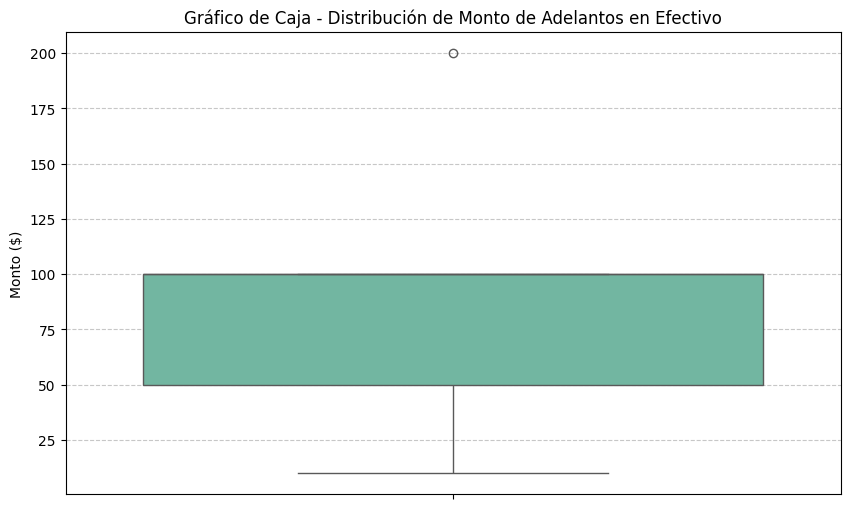

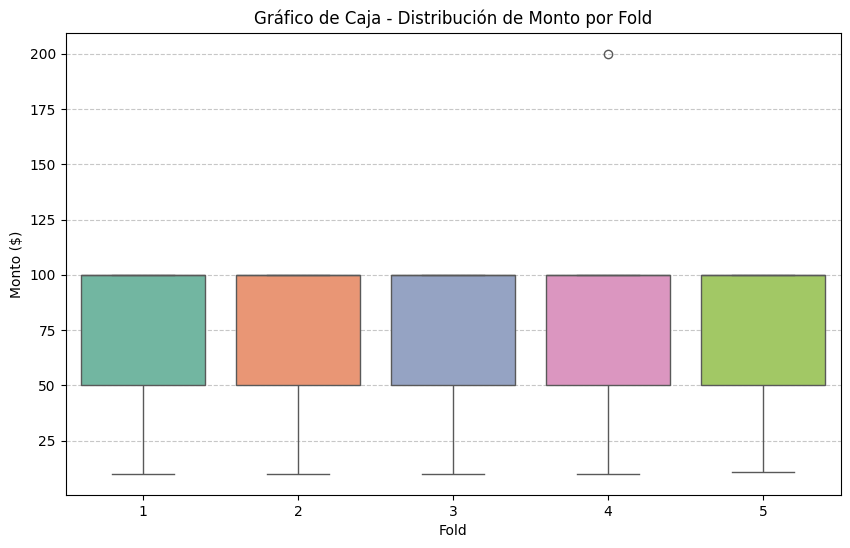

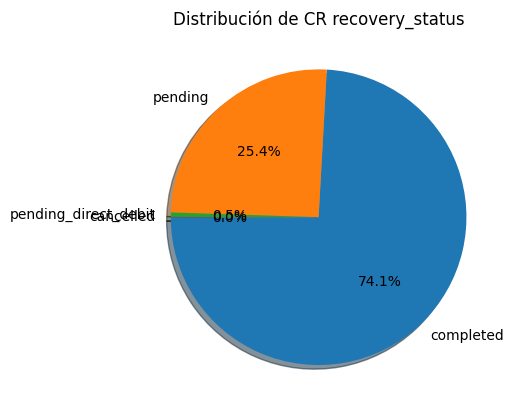

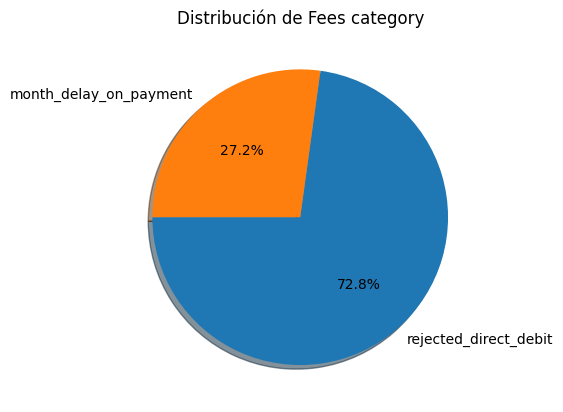

Outliers detectados:
      amount                       created_at recovery_status
2282   200.0 2020-05-05 05:17:40.784144+00:00       completed


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

df_cash_requests = credit_requests
df_fees = fees

# Limpiar los datos del dataset de solicitudes de adelanto en efectivo
df_cash_requests_clean = df_cash_requests[['amount', 'created_at', 'recovery_status']].dropna()
df_cash_requests_clean['created_at'] = pd.to_datetime(df_cash_requests_clean['created_at'])

# Crear el gráfico de caja
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_cash_requests_clean['amount'], palette='Set2', showfliers=True)
plt.title('Gráfico de Caja - Distribución de Monto de Adelantos en Efectivo')
plt.ylabel('Monto ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Función para detectar outliers usando el método del rango intercuartílico (IQR)
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]

# Identificar los outliers en la columna 'amount'
outliers = detectar_outliers(df_cash_requests_clean, 'amount')

# Validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
fold_results = []
for train_index, test_index in kf.split(df_cash_requests_clean):
    train_set, test_set = df_cash_requests_clean.iloc[train_index], df_cash_requests_clean.iloc[test_index]
    fold_results.append(test_set.assign(Fold=fold))
    fold += 1

# Concatenar los resultados de los folds
df_folds = pd.concat(fold_results)

# Gráfico de caja para cada fold
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fold', y='amount', data=df_folds, palette='Set2', showfliers=True)
plt.title('Gráfico de Caja - Distribución de Monto por Fold')
plt.xlabel('Fold')
plt.ylabel('Monto ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico de pastel para recovery_status
c = 'recovery_status'
p = df_cash_requests_clean[c].value_counts().nlargest(4)
p.plot.pie(title=f"Distribución de {c}", legend=False, autopct='%1.1f%%', shadow=True, startangle=180)
plt.ylabel("")
plt.title(f"Distribución de CR {c}")
plt.show()

# Gráfico de pastel para category en fees
c = 'category'
if c in df_fees.columns:
    p = df_fees[c].value_counts()
    p.plot.pie(title=f"Distribución de {c}", legend=False, autopct='%1.1f%%', shadow=True, startangle=180)
    plt.ylabel("")
    plt.title(f"Distribución de Fees {c}")
    plt.show()

# Mostrar los outliers
print("Outliers detectados:")
print(outliers)

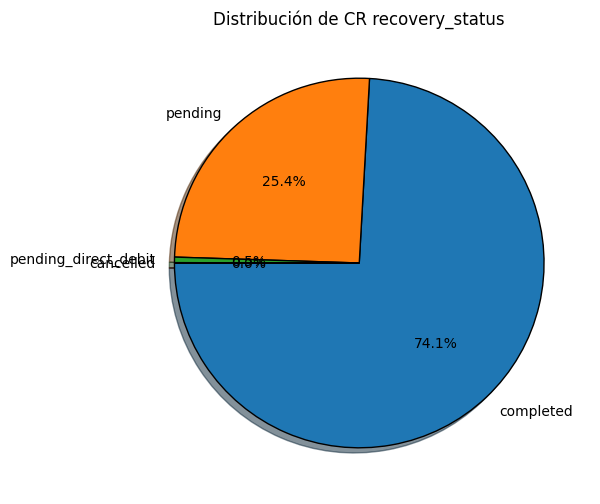

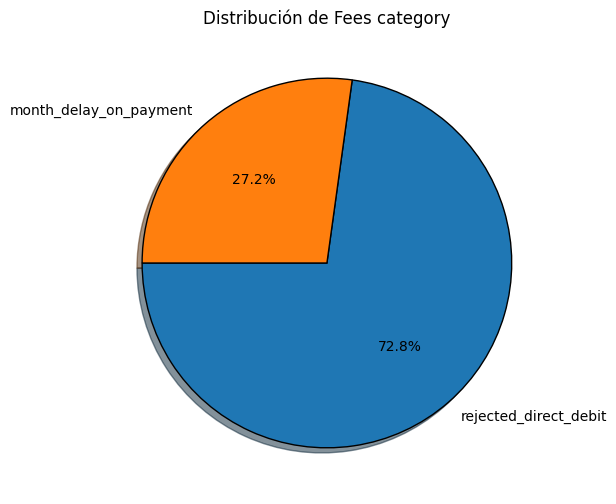

In [80]:
df_cash_requests = credit_requests
df_fees = fees

# Gráfico de pastel para recovery_status
c = 'recovery_status'
p = df_cash_requests[c].value_counts().nlargest(4)
plt.figure(figsize=(8, 6))
plt.pie(p, labels=p.index, autopct='%1.1f%%', shadow=True, startangle=180, wedgeprops={'edgecolor': 'black'})
plt.title(f"Distribución de CR {c}")
plt.show()

# Gráfico de pastel para category en fees
c = 'category'
if c in df_fees.columns:
    p = df_fees[c].value_counts()
    plt.figure(figsize=(8, 6))
    plt.pie(p, labels=p.index, autopct='%1.1f%%', shadow=True, startangle=180, wedgeprops={'edgecolor': 'black'})
    plt.title(f"Distribución de Fees {c}")
    plt.show()

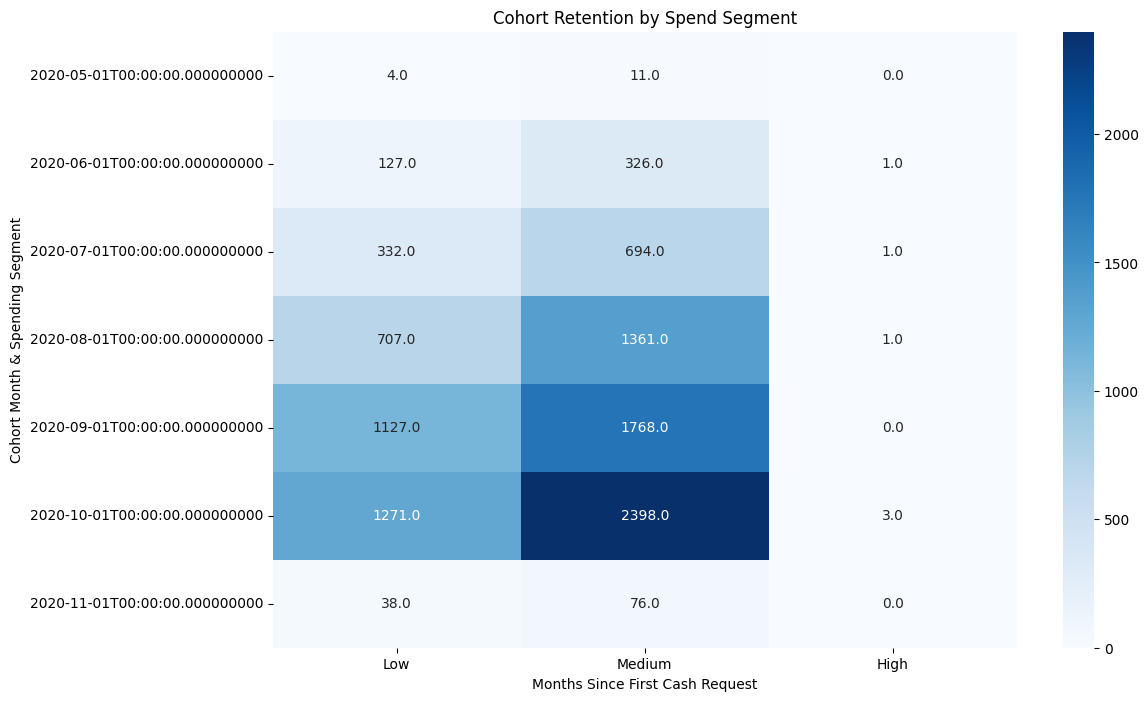

In [52]:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot_spend, annot=True, fmt=".1f", cmap="Blues")
plt.title("Cohort Retention by Spend Segment")
plt.xlabel("Months Since First Cash Request")
plt.ylabel("Cohort Month & Spending Segment")
plt.show()

In [53]:
# Definir los bins y las etiquetas para los segmentos de gasto
bins = [cr['amount'].min(), 50, 150, cr['amount'].max()]
labels = ['Low', 'Medium', 'High']

# Asignar cada usuario a un segmento de gasto
cr['spend_segment'] = pd.cut(cr['amount'], bins=bins, labels=labels, include_lowest=True)

# Crear diccionario para almacenar los user_id por segmento
grouped_users = {
    'Low': cr.loc[cr['spend_segment'] == 'Low', 'user_id'].tolist(),
    'Medium': cr.loc[cr['spend_segment'] == 'Medium', 'user_id'].tolist(),
    'High': cr.loc[cr['spend_segment'] == 'High', 'user_id'].tolist()
}

# Mostrar los resultados
print(grouped_users)

{'Low': [2908.0, 163.0, 2460.0, nan, 21465.0, 23318.0, 115.0, 38075.0, 2575.0, 3131.0, 1628.0, 1003.0, 792.0, 1601.0, nan, 1773.0, 1628.0, 2481.0, nan, 10560.0, 3558.0, 6812.0, 1861.0, nan, nan, 1393.0, 3109.0, 5620.0, nan, 2481.0, 18155.0, 7318.0, 8638.0, 36166.0, 4685.0, 860.0, 5594.0, 597.0, 8564.0, 8157.0, 1895.0, 6792.0, nan, 8040.0, 10203.0, 7780.0, 3377.0, 10516.0, 97141.0, 8857.0, 6461.0, 5496.0, 3849.0, 8456.0, 6345.0, 1022.0, 8674.0, 3377.0, 6511.0, 8720.0, 8638.0, 27816.0, nan, 9953.0, nan, 6929.0, 3377.0, 8873.0, nan, 9308.0, 31320.0, 7903.0, 26854.0, 4508.0, 1159.0, 6162.0, 5284.0, 10208.0, 8986.0, 1776.0, 36013.0, 6931.0, 2274.0, 38553.0, 8831.0, 8787.0, 9442.0, 8412.0, 86577.0, 30482.0, 8707.0, 4916.0, 6879.0, 860.0, 47.0, 8908.0, 9843.0, 16874.0, 14912.0, 8541.0, 9973.0, 2102.0, nan, 29684.0, nan, 4868.0, 8700.0, 22261.0, 38153.0, nan, 30872.0, 20598.0, 25850.0, 25169.0, 17519.0, 10086.0, 10414.0, nan, 14249.0, 6179.0, 20583.0, 15000.0, 13655.0, 2142.0, 12150.0, 13049.0

In [54]:
grouped_users['Low']

[2908.0,
 163.0,
 2460.0,
 nan,
 21465.0,
 23318.0,
 115.0,
 38075.0,
 2575.0,
 3131.0,
 1628.0,
 1003.0,
 792.0,
 1601.0,
 nan,
 1773.0,
 1628.0,
 2481.0,
 nan,
 10560.0,
 3558.0,
 6812.0,
 1861.0,
 nan,
 nan,
 1393.0,
 3109.0,
 5620.0,
 nan,
 2481.0,
 18155.0,
 7318.0,
 8638.0,
 36166.0,
 4685.0,
 860.0,
 5594.0,
 597.0,
 8564.0,
 8157.0,
 1895.0,
 6792.0,
 nan,
 8040.0,
 10203.0,
 7780.0,
 3377.0,
 10516.0,
 97141.0,
 8857.0,
 6461.0,
 5496.0,
 3849.0,
 8456.0,
 6345.0,
 1022.0,
 8674.0,
 3377.0,
 6511.0,
 8720.0,
 8638.0,
 27816.0,
 nan,
 9953.0,
 nan,
 6929.0,
 3377.0,
 8873.0,
 nan,
 9308.0,
 31320.0,
 7903.0,
 26854.0,
 4508.0,
 1159.0,
 6162.0,
 5284.0,
 10208.0,
 8986.0,
 1776.0,
 36013.0,
 6931.0,
 2274.0,
 38553.0,
 8831.0,
 8787.0,
 9442.0,
 8412.0,
 86577.0,
 30482.0,
 8707.0,
 4916.0,
 6879.0,
 860.0,
 47.0,
 8908.0,
 9843.0,
 16874.0,
 14912.0,
 8541.0,
 9973.0,
 2102.0,
 nan,
 29684.0,
 nan,
 4868.0,
 8700.0,
 22261.0,
 38153.0,
 nan,
 30872.0,
 20598.0,
 25850.0,
 2516

## HEAT MAPS POR COHORTE (Low, Medium, High)

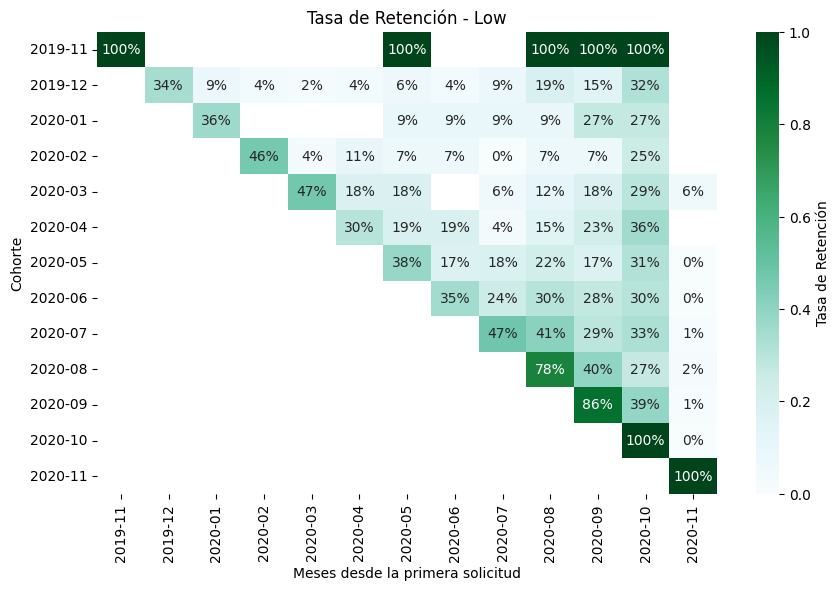

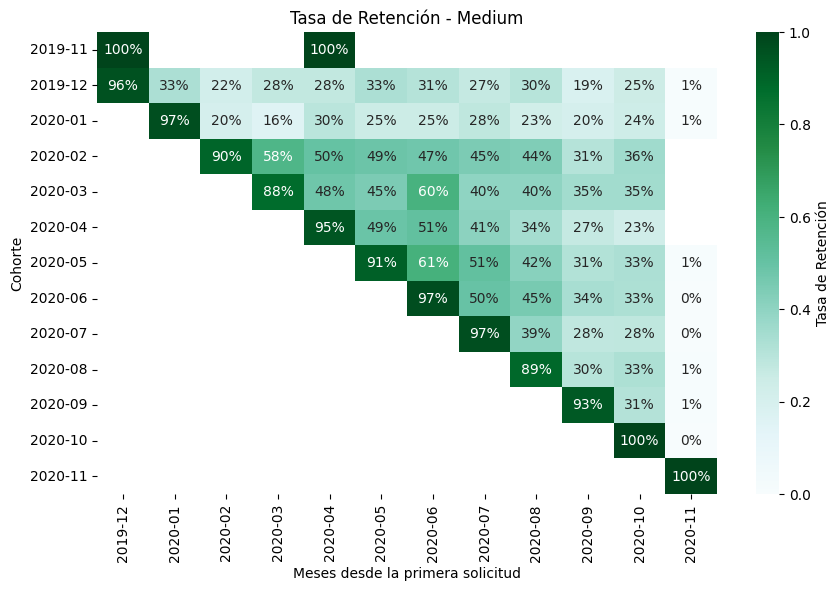

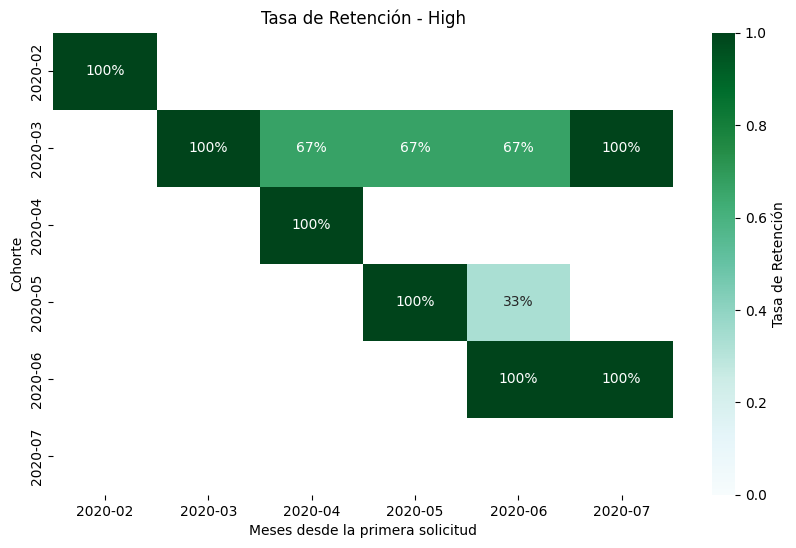

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir los bins y etiquetas para los segmentos de gasto
bins = [cr['amount'].min(), 50, 150, cr['amount'].max()]
labels = ['Low', 'Medium', 'High']

# Asignar cada usuario a un segmento de gasto
cr['spend_segment'] = pd.cut(cr['amount'], bins=bins, labels=labels, include_lowest=True)

# Iterar sobre los segmentos de gasto para generar gráficos separados
for segment in labels:
    # Filtrar datos por segmento
    cohort_segment = cr[cr['spend_segment'] == segment]

    # Calcular la tasa de retención específica por segmento
    retention_clientes_segment = cohort_segment.pivot_table(index='Cohorte',
                                                            columns='Mes',
                                                            values='user_id',
                                                            aggfunc='nunique')
    retention_clientes_segment = retention_clientes_segment.div(cohort_segment.groupby('Cohorte')['user_id'].nunique(), axis=0)

    # Crear un gráfico individual para cada segmento
    plt.figure(figsize=(10, 6))
    plt.title(f'Tasa de Retención - {segment}')

    # Visualizar la tasa de retención con un mapa de calor
    sns.heatmap(data=retention_clientes_segment, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='BuGn', cbar_kws={'label': 'Tasa de Retención'})

    plt.xlabel('Meses desde la primera solicitud')
    plt.ylabel('Cohorte')

    # Mostrar el gráfico
    plt.show()

**Ahora Acumulado**

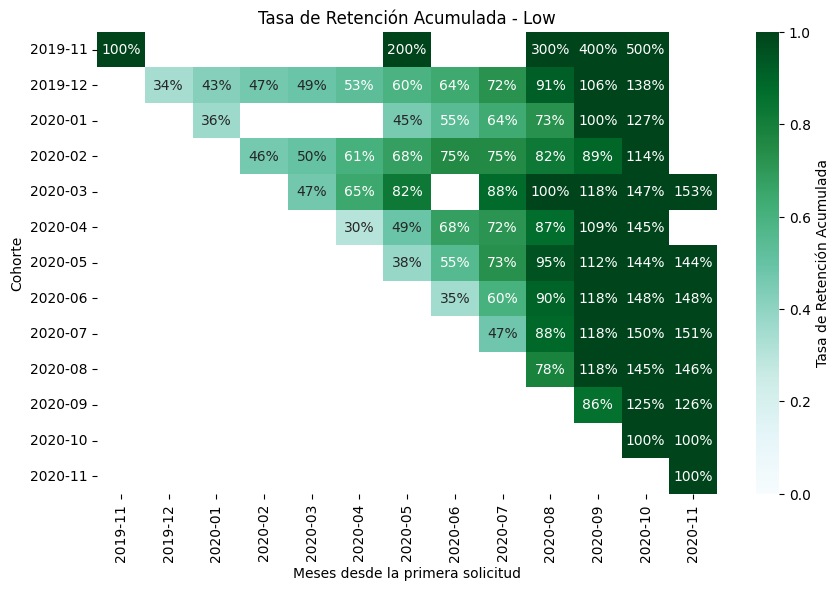

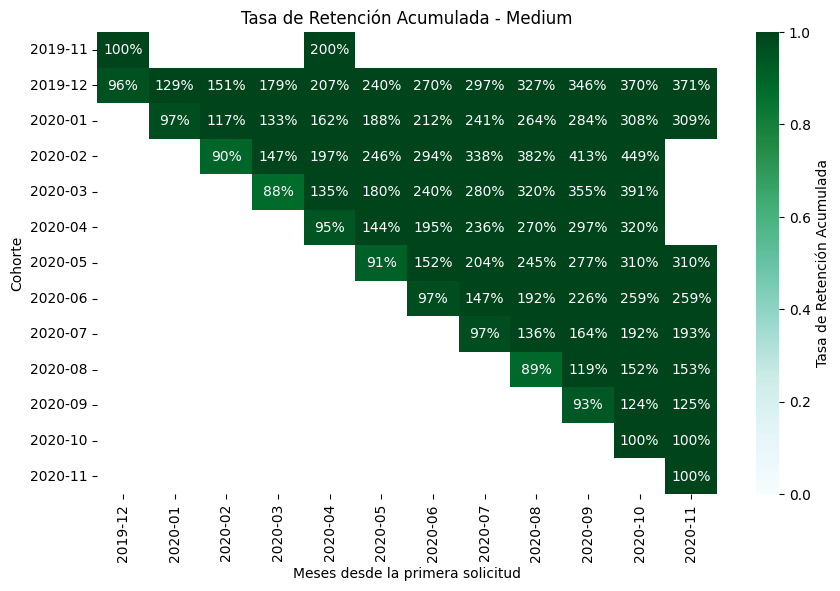

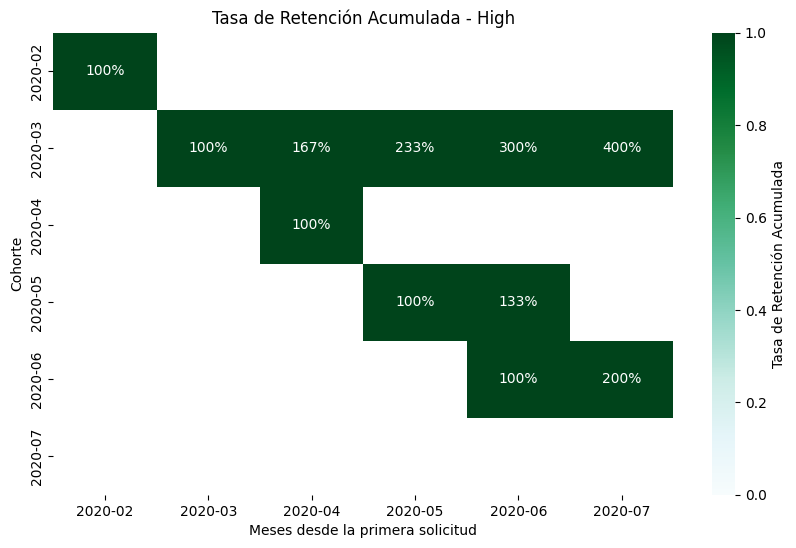

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir los bins y etiquetas para los segmentos de gasto
bins = [cr['amount'].min(), 50, 150, cr['amount'].max()]
labels = ['Low', 'Medium', 'High']

# Asignar cada usuario a un segmento de gasto
cr['spend_segment'] = pd.cut(cr['amount'], bins=bins, labels=labels, include_lowest=True)

# Iterar sobre los segmentos de gasto para generar gráficos separados con valores acumulados
for segment in labels:
    # Filtrar datos por segmento
    cohort_segment = cr[cr['spend_segment'] == segment]

    # Calcular la tasa de retención específica por segmento
    retention_clientes_segment = cohort_segment.pivot_table(index='Cohorte',
                                                            columns='Mes',
                                                            values='user_id',
                                                            aggfunc='nunique')

    # Convertir los valores en acumulativos (suma progresiva por fila)
    retention_clientes_segment = retention_clientes_segment.cumsum(axis=1)

    # Normalizar dividiendo por la cantidad inicial de usuarios en cada cohorte
    retention_clientes_segment = retention_clientes_segment.div(cohort_segment.groupby('Cohorte')['user_id'].nunique(), axis=0)

    # Crear un gráfico individual para cada segmento
    plt.figure(figsize=(10, 6))
    plt.title(f'Tasa de Retención Acumulada - {segment}')

    # Visualizar la tasa de retención con un mapa de calor
    sns.heatmap(data=retention_clientes_segment, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='BuGn', cbar_kws={'label': 'Tasa de Retención Acumulada'})

    plt.xlabel('Meses desde la primera solicitud')
    plt.ylabel('Cohorte')

    # Mostrar el gráfico
    plt.show()


**LOW**

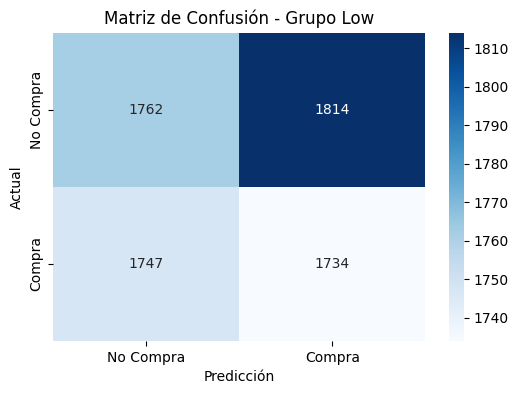

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Filtrar los datos del grupo 'Low'
low_users = merged_df.loc[merged_df['spend_segment'] == 'Low', 'user_id'].tolist()

# Simulación de etiquetas reales y predichas para los usuarios en 'Low'
actual_labels = np.random.choice([0, 1], size=len(low_users))  # Etiquetas reales (0: No compra, 1: Compra)
predicted_labels = np.random.choice([0, 1], size=len(low_users))  # Etiquetas predichas

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['No Compra', 'Compra'], yticklabels=['No Compra', 'Compra'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Grupo Low')
plt.show()

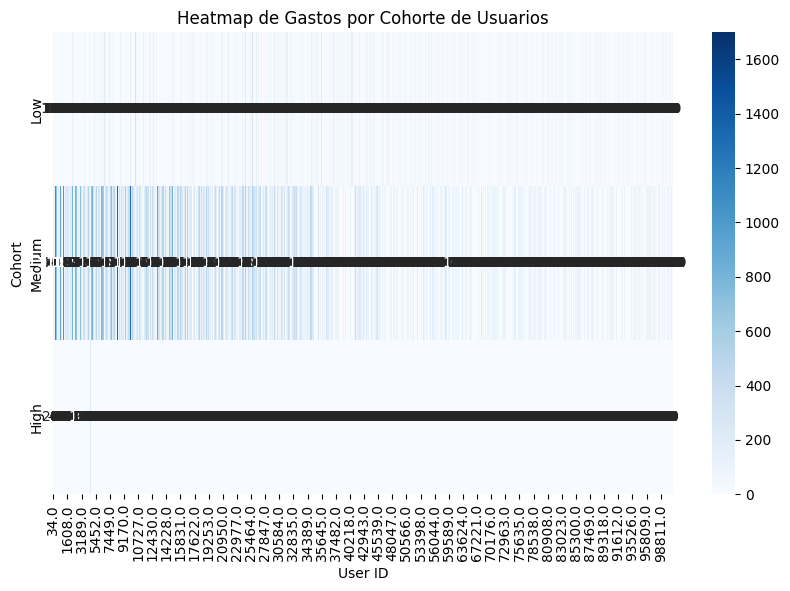

In [58]:
# Crear tabla de cohortes
cohort_table = cr.pivot_table(index='spend_segment', columns='user_id', values='amount', aggfunc='sum', fill_value=0)

# Crear el heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cohort_table, cmap='Blues', annot=True, fmt='g')
plt.title('Heatmap de Gastos por Cohorte de Usuarios')
plt.xlabel('User ID')
plt.ylabel('Cohort')
plt.show()

## MODELO SMV

In [59]:
# Aggregate user-level data
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score

user_features = merged_df.groupby('user_id').agg(
    num_requests=('user_id', 'count'),  # Total requests per user
    avg_amount=('amount', 'mean'),  # Average amount per request
    total_amount=('amount', 'sum'),  # Total borrowed amount
    first_request_month=('Month_cash_request', 'min'),  # First request date
    last_request_month=('Month_cash_request', 'max'),  # Last request date
    fees_paid=('total_amount', 'sum')  # Total fees paid
).reset_index()

# Convert first request month into categorical time periods
user_features['first_request_month'] = pd.to_datetime(user_features['first_request_month'], errors='coerce')
user_features['last_request_month'] = pd.to_datetime(user_features['last_request_month'], errors='coerce')


# Calculate user activity duration in days
user_features['user_lifetime'] = (user_features['last_request_month'] - user_features['first_request_month']).dt.days

# Convert first request month into categorical time periods (YYYY-MM format)
user_features['first_request_month'] = user_features['first_request_month'].dt.to_period('M')

# Classify users into spending segments
def classify_segment(amount):
    if amount < 100:  # Define thresholds based on data distribution
        return 'Low'
    elif amount < 500:
        return 'Medium'
    else:
        return 'High'

user_features['spend_segment'] = user_features['total_amount'].apply(classify_segment)

# Drop unnecessary columns
user_features = user_features.drop(columns=['last_request_month'])

user_features
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Set The Random Seed
random_seed=42

# Seprate the Features and the Target coulmns
target=user_features['spend_segment']
features=user_features.drop(columns=['user_id','spend_segment', 'first_request_month'])

# Convert datetime to numeric months


# Encode the spend_segment by LbabelEncoder
label_encoder=LabelEncoder()
target=label_encoder.fit_transform(target)

# Scale The Features With StandardScaler
standard_scaler= StandardScaler()
features= standard_scaler.fit_transform(features)

# Split Data for Interpolationa, Extrapolation, Train and Test
X_interap, X_extrap, y_interap, y_extrap= train_test_split(features, target, test_size=0.3, random_state= random_seed, shuffle=False)
# X_train, X_test, Y_train, Y_test = train_test_split(X_interap, y_interap, test_size=0.2, random_state=random_seed, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_interap, y_interap, test_size=0.3, random_state=random_seed, shuffle=True)

# Create a SVM Model With RBF Kernel
svm_model= SVC(kernel='rbf', C=1, gamma=0.1, probability=True)

# Perform 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
cv_scores = cross_val_score(svm_model, features, target, cv=kf, scoring='accuracy')

# Display cross-validation results
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation of Accuracy:", np.std(cv_scores))


svm_model.fit(X_train, y_train)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py", line 197, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


## BOUNDARY

In [ ]:
from sklearn.decomposition import PCA
# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Transform training data
X_test_pca = pca.transform(X_test)

# Train SVM on PCA-reduced data
svm_pca_model = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm_pca_model.fit(X_train_pca, y_train)

# Visualize the descision area
# Define mesh step size
h_svm = 0.02

# Extract PCA feature limits
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()
X_extrap_pca = pca.fit_transform(X_extrap)  # Transform training data

# Visualize the descision area
# Define mesh step size
h_svm = 0.02

# Extract PCA feature limits
x_min, x_max = X_extrap_pca[:, 0].min() - 1, X_extrap_pca[:, 0].max() + 1
y_min, y_max = X_extrap_pca[:, 1].min() - 1, X_extrap_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_extrap_pca[:, 0], X_extrap_pca[:, 1], c=y_extrap, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer


# Classification Report For The Test Data
y_pred_test = svm_model.predict(X_test)

# Print accuracy
from sklearn.metrics import accuracy_score, classification_report
print('-'*50,'\n','Test')
print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Confusion Matrix
cm_svm= confusion_matrix(y_test, y_pred_test)
print(cm_svm)

y_pred_extrap = svm_model.predict(X_extrap)

print('-'*50,'\n','Extrapolation')
print("SVM Model Accuracy:", accuracy_score(y_extrap, y_pred_extrap))
print("Classification Report:\n", classification_report(y_extrap, y_pred_extrap))
cm_svm_extrap= confusion_matrix(y_extrap, y_pred_extrap)
print(cm_svm_extrap)
from sklearn.preprocessing import LabelBinarizer
# AUC for each class
lb_svm= LabelBinarizer()
y_test_bin= lb_svm.fit_transform(y_test)
y_pred_prob_test= svm_model.predict_proba(X_test)

y_extrap_bin= lb_svm.fit_transform(y_extrap)
y_pred_prob_extrap= svm_model.predict_proba(X_extrap)


# Calculate the AUC for each class
auc_scores_test=[]

for i in range(y_test_bin.shape[-1]):
    auc_test= roc_auc_score(y_test_bin[:,i], y_pred_prob_test[:,i])
    auc_scores_test.append(auc_test)

auc_scores_extrap=[]

for i in range(y_extrap_bin.shape[1]):
    auc_extrapt= roc_auc_score(y_extrap_bin[:,i], y_pred_prob_extrap[:,i])
    auc_scores_extrap.append(auc_test)

# Print the AUC for Each Class in The Test
print('-'*50)
print('Interpolation')
for i , auc_test in enumerate(auc_scores_test):
    print(f"AUC pf the class{i}: {auc_test}")
print('-'*50)
print('Extrapolation')
# Print the AUC for Each Class in The Test
for i , auc_extrap in enumerate(auc_scores_extrap):
    print(f"AUC pf the class{i}: {auc_extrap}")

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Kernel types
}

# Create SVM model
svm_model = SVC(probability=True)
# Define K-Fold Cross-Validation strategy (Stratified ensures class balance)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Implement GridSearchCV with K-Fold CV
grid_search = GridSearchCV(svm_model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=3)


# Fit on training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Evaluate the best model on test data
test_accuracy = best_svm_model.score(X_test, y_test)
print("Test Accuracy of Best Model:", test_accuracy)

In [ ]:
from sklearn.decomposition import PCA
# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Transform training data
X_test_pca = pca.transform(X_test)

# Train SVM on PCA-reduced data
svm_pca_best_model = SVC(kernel='linear', C=100, gamma=0.01, probability=True)
svm_pca_best_model.fit(X_train_pca, y_train)

# Visualize the descision area
# Define mesh step size
h_svm = 0.02

# Extract PCA feature limits
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

In [ ]:
X_extrap_pca = pca.fit_transform(X_extrap)  # Transform training data


# Visualize the descision area
# Define mesh step size
h_svm = 0.02

# Extract PCA feature limits
x_min, x_max = X_extrap_pca[:, 0].min() - 1, X_extrap_pca[:, 0].max() + 1
y_min, y_max = X_extrap_pca[:, 1].min() - 1, X_extrap_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_extrap_pca[:, 0], X_extrap_pca[:, 1], c=y_extrap, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

In [ ]:
# AUC for each class
lb_svm= LabelBinarizer()
y_test_bin= lb_svm.fit_transform(y_test)
y_pred_prob_test= best_svm_model.predict_proba(X_test)

y_extrap_bin= lb_svm.fit_transform(y_extrap)
y_pred_prob_extrap= best_svm_model.predict_proba(X_extrap)


# Calculate the AUC for each class
auc_scores_test=[]

for i in range(y_test_bin.shape[-1]):
    auc_test= roc_auc_score(y_test_bin[:,i], y_pred_prob_test[:,i])
    auc_scores_test.append(auc_test)

auc_scores_extrap=[]

for i in range(y_extrap_bin.shape[1]):
    auc_extrapt= roc_auc_score(y_extrap_bin[:,i], y_pred_prob_extrap[:,i])
    auc_scores_extrap.append(auc_test)

# Print the AUC for Each Class in The Test
print('-'*50)
print('Interpolation')
for i , auc_test in enumerate(auc_scores_test):
    print(f"AUC pf the class{i}: {auc_test}")
print('-'*50)
print('Extrapolation')
# Print the AUC for Each Class in The Test
for i , auc_extrap in enumerate(auc_scores_extrap):
    print(f"AUC pf the class{i}: {auc_extrap}")

## **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Set up the KNN model with n_neighbors= 10
n_neighbors= 10
knn_model = KNeighborsClassifier(n_neighbors = n_neighbors)
knn_model.fit(X_train, y_train)

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Transform training data
X_test_pca = pca.transform(X_test)

# Train SVM on PCA-reduced data
knn_pca_model = KNeighborsClassifier(n_neighbors = n_neighbors)
knn_pca_model.fit(X_train_pca, y_train)

# Visualize the descision area
# Define mesh step size
h_knn = 0.02

# Extract PCA feature limits
x_min_knn, x_max_knn = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min_knn, y_max_knn = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min_knn, x_max_knn, h_knn),
    np.arange(y_min_knn, y_max_knn, h_knn)
)

# Predict on mesh grid using SVM trained on PCA data
Z = knn_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("KNN Decision Boundary with PCA")
plt.show()

In [ ]:
pca = PCA(n_components=2)
X_extrap_pca = pca.fit_transform(X_extrap)  # Transform training data
X_extrap_pca = pca.transform(X_extrap)


# Visualize the descision area
# Define mesh step size
h_knn = 0.02

# Extract PCA feature limits
x_min_knn, x_max_knn = X_extrap_pca[:, 0].min() - 1, X_extrap_pca[:, 0].max() + 1
y_min_knn, y_max_knn = X_extrap_pca[:, 1].min() - 1, X_extrap_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min_knn, x_max_knn, h_knn),
    np.arange(y_min_knn, y_max_knn, h_knn)
)

# Predict on mesh grid using SVM trained on PCA data
Z = knn_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, camp='viridis')
plt.scatter(X_extrap_pca[:, 0], X_extrap_pca[:, 1], c=y_extrap, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("Classification With KNN , n_neighbors = 10")
plt.show()

In [ ]:
y_pred_test_knn = knn_model.predict(X_test)
y_pred_extrap_knn= knn_model.predict(X_extrap)

print('Classification Report:')
print(classification_report(y_test, y_pred_test_knn))
print(classification_report(y_extrap, y_pred_extrap_knn))

cm_matrix_test = confusion_matrix(y_test,y_pred_test_knn)
print('Confusion Matrix for the test data:')
print(cm_matrix_test)

cm_matrix_extrap = confusion_matrix(y_extrap,y_pred_extrap_knn)
print('Confusion Matrix for the extrapolation data:')
print(cm_matrix_extrap)

# AUC for each class
lb_knn= LabelBinarizer()
y_test_bin= lb_svm.fit_transform(y_test)
y_pred_prob_test= knn_model.predict_proba(X_test)

y_extrap_bin= lb_knn.fit_transform(y_extrap)
y_pred_prob_extrap= knn_model.predict_proba(X_extrap)


# Calculate the AUC for each class
auc_scores_test=[]

for i in range(y_test_bin.shape[-1]):
    auc_test= roc_auc_score(y_test_bin[:,i], y_pred_prob_test[:,i])
    auc_scores_test.append(auc_test)

auc_scores_extrap=[]

for i in range(y_extrap_bin.shape[1]):
    auc_extrapt= roc_auc_score(y_extrap_bin[:,i], y_pred_prob_extrap[:,i])
    auc_scores_extrap.append(auc_test)

# Print the AUC for Each Class in The Test
print('-'*50)
print('Interpolation')
for i , auc_test in enumerate(auc_scores_test):
    print(f"AUC pf the class{i}: {auc_test}")
print('-'*50)
print('Extrapolation')
# Print the AUC for Each Class in The Test
for i , auc_extrap in enumerate(auc_scores_extrap):
    print(f"AUC pf the class{i}: {auc_extrap}")

In [ ]:
k_values_knn = range(1, 20)
accuracies_knn = []

for k_knn in k_values_knn :
    Knn_model = KNeighborsClassifier(n_neighbors = k_knn)
    scores_knn= cross_val_score(knn_model, X_train , y_train,cv=5)
    accuracies_knn.append(scores_knn.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values_knn, accuracies_knn, marker='o')
plt.title('($k$) Parameter Optimization')
plt.ylabel('average precision')
plt.show()